In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# constants
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT
NUM_EPOCHS = 10
BATCH_SIZE = 100
EVAL_FREQUENCY = 200

In [3]:
# download dataset
mnist = input_data.read_data_sets(".", one_hot = False)
print "size of training set:", mnist.train.num_examples
print "size of validation set:", mnist.validation.num_examples
print "size of test set", mnist.test.num_examples

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
size of training set: 55000
size of validation set: 5000
size of test set 10000


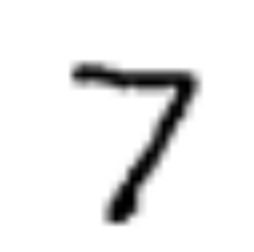

In [4]:
# visualize data
def display(img):
    one_image = img.reshape(IMAGE_WIDTH, IMAGE_HEIGHT)
    plt.axis('off')
    plt.imshow(one_image, cmap = cm.binary)

display(mnist.test._images[0])

In [5]:
# define layers
def conv(input, width, height, channels, stddev = 0.1, bias = 0.1):
    input_channels = input.get_shape().as_list()[3]
    w = tf.Variable(tf.truncated_normal([width, height, input_channels, channels], stddev = stddev))
    b = tf.Variable(tf.constant(bias, shape = [channels]))
    net = tf.nn.conv2d(input, w, strides = [1, 1, 1, 1], padding = 'SAME')
    net = tf.nn.bias_add(net, b)
    net = tf.nn.relu(net)
    return net

def pool(input):
    net = tf.nn.max_pool(input, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return net

def fc(input, output_dim, stddev = 0.1, bias = 0.1):
    input_dim = input.get_shape().as_list()[1]
    w = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev = stddev))
    b = tf.Variable(tf.constant(bias, shape = [output_dim]))
    net = tf.matmul(input, w) + b
    net = tf.nn.relu(net)
    return net

def flatten(input):
    return tf.reshape(input, [-1, np.prod(net.get_shape().as_list()[1: ])])

In [6]:
# define placeholders
x = tf.placeholder(tf.float32, shape = [None, IMAGE_SIZE])
y_ = tf.placeholder(tf.int64, shape = [None])
keep_prob = tf.placeholder(tf.float32)

In [7]:
# define network
net = tf.reshape(x, [-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1])
conv1 = net = conv(net, width = 5, height = 5, channels = 32)
pool1 = net = pool(net)
conv2 = net = conv(net, width = 5, height = 5, channels = 64)
pool2 = net = pool(net)
flat = net = flatten(net)
fc1 = net = fc(net, 512)
drop = net = tf.nn.dropout(net, keep_prob)
fc2 = net = fc(net, 10)
logits = fc2

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), y_), tf.float32))

train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [8]:
# define tensor for visualization of conv1
visualization = tf.reshape(conv1, (-1, IMAGE_HEIGHT, IMAGE_WIDTH, 4, 8))  
visualization = tf.transpose(visualization, (0, 3, 1, 4, 2))
visualization = tf.reshape(visualization, (-1, IMAGE_HEIGHT * 4, IMAGE_WIDTH * 8))

def visualize(sess, input_x):
    figure = sess.run(visualization, feed_dict = {x : input_x, keep_prob : 1.0})
    plt.axis('off')
    plt.imshow(figure[0], cmap = cm.seismic)

In [9]:
def eval_on_dataset(dataset):
    cnt = 0
    sum = 0
    assert dataset.num_examples % BATCH_SIZE == 0
    for i in xrange(0, dataset.num_examples, BATCH_SIZE):
        cnt += 1
        batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
        sum += sess.run(accuracy, {x: batch_xs, y_: batch_ys, keep_prob: 1.0})
    sum = sum / cnt
    return sum

In [10]:
# train

# start a session
sess = tf.InteractiveSession()

# initialize variables
sess.run(tf.initialize_all_variables())

for step in xrange(1, 1 + int(NUM_EPOCHS * mnist.train.num_examples // BATCH_SIZE)):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    # one single train step
    sess.run(train_op, {x: batch_xs, y_: batch_ys, keep_prob: 0.5})
    if step % EVAL_FREQUENCY == 0:
        # evaluation
        train_accuracy = eval_on_dataset(mnist.train)
        validation_accuracy = eval_on_dataset(mnist.validation)
        print "Step %d, train accuracy = %.3f, validation accuracy = %.3f" % (step, train_accuracy, validation_accuracy)

# final evaluation
print "Step %d, train accuracy = %.3f, validation accuracy = %.3f" % (step, train_accuracy, validation_accuracy)

Step 200, train accuracy = 0.190, validation accuracy = 0.190
Step 400, train accuracy = 0.801, validation accuracy = 0.803
Step 600, train accuracy = 0.944, validation accuracy = 0.944
Step 800, train accuracy = 0.958, validation accuracy = 0.958
Step 1000, train accuracy = 0.965, validation accuracy = 0.963
Step 1200, train accuracy = 0.971, validation accuracy = 0.970
Step 1400, train accuracy = 0.974, validation accuracy = 0.977
Step 1600, train accuracy = 0.977, validation accuracy = 0.978
Step 1800, train accuracy = 0.979, validation accuracy = 0.982
Step 2000, train accuracy = 0.980, validation accuracy = 0.983
Step 2200, train accuracy = 0.982, validation accuracy = 0.983
Step 2400, train accuracy = 0.981, validation accuracy = 0.981
Step 2600, train accuracy = 0.984, validation accuracy = 0.983
Step 2800, train accuracy = 0.986, validation accuracy = 0.987
Step 3000, train accuracy = 0.986, validation accuracy = 0.985
Step 3200, train accuracy = 0.988, validation accuracy = 0.

In [11]:
# evaluate on test set
print eval_on_dataset(mnist.test)

0.993699973226


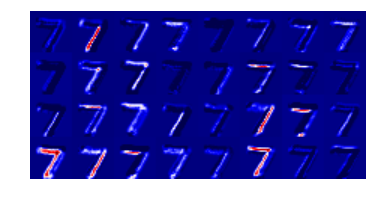

In [12]:
# visualize intermediate result
visualize(sess, mnist.test.images[0: 1])